# Finding sprints --- Formally

Assume that you are a soccer manager. I do not know how but you are interested in formal methods to analyse the behavior of your players on the pitch. You have player data and a definition of sprint (This is really really important!). Then you can write your sprint definition in a pattern specification language (like timed regular expressions) and search for all segments where a sprint occurred. Right now we'll do it!

Here I start by saying that a **sprint** occurs on a time period such that a period of **medium or high acceleration** followed by a period of **very high speed** for **1 second at least**. This is my definition of a sprint. Ok, fine, but it is a bit vague, right? What is medium acceleration, or what is very high speed? For this, I have looked into some articles in the sports science literature and found a nice article: <http://www.catapultsports.com/media/3292/global-positioning-system-data-analysis-velocity-ranges-and-a-new-definition-of-sprinting-for-field-sport-athletes.pdf>, from which I extract some threshold values and I categorize speed and acceleration domain.

First I associate each category with a letter (symbol). For example, the category of positive medium acceleration (between 1.17 and 1.60 m/s^2) is denoted by the letter *f*. Similarly the category of very high speed (between 6 and 20 m/s) is denoted by the letter *s*.

In [13]:
# Speed (m/s) and acceleration (m/s^2) categories 

accel_desc = ['nhigh','nmedium', 'nlow','around_zero', 'low', 'medium', 'high']
accel_syms = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
accel_bins = [-100, -1.60, -1.17,-0.57, 0.57, 1.17, 1.60, 100]

speed_desc = ['low', 'medium', 'high', 'very_high']
speed_syms = ['p', 'q', 'r', 's']
speed_bins = [-1.0, 2, 3.7, 6, 20]

Using this symbols we can write our sprint definition as a timed regular expression. A period of medium or high acceleration is written as "f || g". The period of very high speed for 1 second at least is written as "s % (1000,\_)". Then the concatenation of these expressions would be "(f||g);(s%(1000,\_))" where time units are in microseconds for this demo. Then we add some anchors ("<:" and ":>") on symbols to fix beginning and endings of matches to rising and falling edges. However, for now, you may skip anchors or look at the documentation for more information. 

In [14]:
#
### Defining a timed pattern (as a timed regular expression)
#
###     SYMBOLS
### f : Medium positive acceleration
### g : High positive acceleration
### s : Very high speed
#
# Pattern description: A period of medium or high acceleration followed by 
# a period of very high speed for 1 second at least.
#
# Time units are in microseconds.
#

PATTERN = "\'(<:(f||g));((<:s:>)%(1000,100000))\'"

I will use Python and its nice libraries to process data. Let's set up the environment.

In [15]:
%matplotlib inline

# In order to process data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# In order to call Montre
import subprocess, shlex

In this demo I use data from a real football match, Galatasaray v Sivasspor, played at January 16th, 2016. My favorite team Galatasaray won the game so everything is fine. More info about the match (like jersey numbers of players, we'll use later.) can be found here: <http://www.goal.com/en/match/galatasaray-vs-sivasspor/2074488/lineups>. These data are obtained by a sport analytics company, Sentio (<http://sentiosports.com>). Their soccer player tracking technology tracks players by using state-of-the-art computer vision and machine learning algorithms. But here I just use the output of these algorithms: Raw coordinates of players monitored with a rate of 10 samples per second for 90 minutes. We read the data from a csv file.

In [16]:
# Sentio constants 
FRAME_PER_SECOND = 10

# Read Sentio data
df = pd.read_csv('data/match.csv', index_col=["MINUTE", "SECOND", 'TIMESTAMP'], header=0, 
                 names=["TIMESTAMP", "HALF", "MINUTE", "SECOND", "TEAM_ID", 
                        "JERSEY_NUMBER", "X_POS", "Y_POS", "DISTANCE", "SPEED"])

Now I choose a player to find his sprints during the match. My usual suspect is Olcan Adin (Jersey Number #29) from Galatasaray (Team #1). I choose him because he is a winger and usually sprints more than others. The Dutch may choose their precious Wesley Sneijder (#10) as well. Also I specify whether we want to find sprints in the first half or the second half.

In [17]:
# Usual Suspect
PLAYER_TEAM = 1     # Galatasaray
PLAYER_NUMBER = 29  # Olcan Adin
HALF = 1

# Select the data for the specific player
data = df[(df['TEAM_ID'] == PLAYER_TEAM) & 
          (df['JERSEY_NUMBER'] == PLAYER_NUMBER) & 
          (df['HALF'] == HALF)].copy(deep=True)

I first sort the data according to timestamps/seconds/minutes and then introduce a single time axis. Besides the tracking technology sometimes is getting confused and misses some samples therefore I first fill these values by interpolation. 

In [18]:
data['TIME'] = pd.Series(range(len(data)), index=data.index)
data = data.set_index(['TIME'])
data = data.drop(['HALF', 'TEAM_ID', "JERSEY_NUMBER", "DISTANCE", "SPEED"], axis=1).copy(deep=True)

data.loc[data['X_POS'] < 0, 'X_POS'] = np.nan; data['X_POS'] = data['X_POS'].interpolate()
data.loc[data['Y_POS'] < 0, 'Y_POS'] = np.nan; data['Y_POS'] = data['Y_POS'].interpolate()

If you would like to see the movement of the player, it's here:

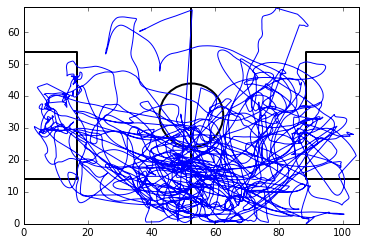

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')  

# Draw a simple soccer pitch (105x68m)
ax.set_ylim(0,68)
ax.set_xlim(0,105)
plt.plot([52.5,52.5], [0,68], color='black', linewidth=2)
plt.plot([0,16.5,16.5,0], [54,54, 14,14], color='black', linewidth=2)
plt.plot([105,105-16.5,105-16.5,105], [54,54,14,14], color='black', linewidth=2)
circle1=plt.Circle((52.5,34),10, color='black', linewidth=2, fill=False)
ax.add_artist(circle1)

plt.plot(data['X_POS'],data['Y_POS'])

I calculate displacement, speed and accelaration from x-y coordiates. Here some Euclidian geometry and Newtonian mechanics:

In [20]:
data['DISPLACEMENT'] =  np.sqrt((data['X_POS'].diff())**2 + (data['Y_POS'].diff())**2)
data['DISPLACEMENT'][0] = 0

data['SPEED'] = np.abs(data['DISPLACEMENT']) * FRAME_PER_SECOND

data['ACCEL'] = data['SPEED'].diff() * FRAME_PER_SECOND
data['ACCEL'][0] = 0
data['ACCEL'][1] = 0

# In case more smoothing is needed.
# data['SPEED'][2:] = data['SPEED'].rolling(center=False,window=3).mean()[2:]
# data['ACCEL'][2:] = data['ACCEL'].rolling(center=False,window=3).mean()[2:]


Finally I apply speed and acceleration categories and I obtain symbolic speed and acceleration behaviors.

In [21]:
data['SPEEDSYM'] = pd.cut(data['SPEED'], bins=speed_bins, labels=speed_syms)
data['ACCELSYM'] = pd.cut(data['ACCEL'], bins=accel_bins, labels=accel_syms)

I write symbolic behaviors into a file called INPUT.txt. 

In [22]:
def collect(x, *ys):

    y = [''.join(str(i) for i in e) for e in zip(*ys)]
        
    xp = x[0]
    yp = y[0]
    for (xi, yi) in zip(x,y):
        if yi != yp:
            yield (xi-xp,yp)
            xp = xi
            yp = yi
    yield (xi-xp,yp)

with open('INPUT.txt', 'w') as f:
    for (xi, yi) in collect(data.index.values, list(data['ACCELSYM'].values), list(data['SPEEDSYM'].values)):
        f.write('{0} {1}\n'.format(xi*100, yi))

Here the first 5 lines of the input file looks like this. The duration of the segment (in microseconds) and the symbols for speed and acceleration categories. For example "300 cq" means that a negative low acceleration (c) and medium speed (q) are observed for 300 microseconds.

In [23]:
with open('INPUT.txt', 'r') as f:
    for i in range(5):
        print(f.readline())

100 dp

200 dq

300 cq

300 dq

100 cq



Now I call Montre to perform timed pattern matching for given PATTERN and the file INPUT.txt.

In [26]:
command = shlex.split("montre" + " " + "-b" + " " + PATTERN + " " + "-f" + " " + "INPUT.txt" + " " + "-o" + " " + "OUTPUT.txt")
subprocess.call(command)

FileNotFoundError: [WinError 2] The system cannot find the file specified

Now the output containing zones is in the OUTPUT.txt. Look at the the first line, showing a zone of occurrences for the pattern given.

In [ ]:
with open('OUTPUT.txt', 'r') as f:
    print(f.readline())

It is equal to the following inequalites:

In [ ]:
%%latex
\begin{equation*}
144800 \leq t \leq 148800\\
144800 \leq t' \leq 148800\\
4000 \leq t' -t \leq 4000
\end{equation*}

This region contains only one time segment (144800, 148800) and it is when a sprint occurred. In other word there is a sprint of Olcan Adin starting at 144.8s and ending at 148.8s, which is 4-second long. In general, zones can contain uncountable number of occurrences however here remember that we have restricted start and end times of a match by using anchors in the pattern. That's why we end up zone with a single point inside.

The last thing is to visualise all sprints found on the pitch.

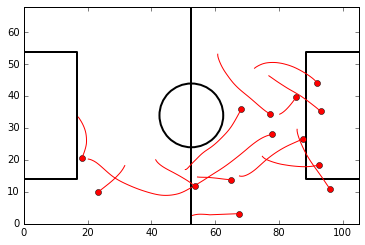

In [25]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, aspect='equal') 

# Draw a simple soccer pitch (105x68m)
ax2.set_ylim(0,68)
ax2.set_xlim(0,105)
ax2.plot([52.5,52.5], [0,68], color='black', linewidth=2)
ax2.plot([0,16.5,16.5,0], [54,54, 14,14], color='black', linewidth=2)
ax2.plot([105,105-16.5,105-16.5,105], [54,54,14,14], color='black', linewidth=2)
circle1=plt.Circle((52.5,34),10, color='black', linewidth=2, fill=False)
ax2.add_artist(circle1)

with open('OUTPUT.txt', 'r') as f:
    for line in f:
        line = line.strip()
        column = line.split()
        begin, end = int(column[1])//100, int(column[2])//100

        x = data['X_POS'][begin:end]
        y = data['Y_POS'][begin:end]
        ax2.plot(x.iloc[-1], y.iloc[-1], 'o', color="red")
        ax2.plot(x, y, color="red")

## Conclusion

We have shown how to perform timed pattern matching over speed and acceleration signals to find all instances of a pattern (e.g. sprints). Perhaps the most important thing in the process is to come up a good pattern definition. And clearly this is not easy and it requires some domain knowledge at the first hand. But, once you have a pattern, the problem can be solved easily by using Montre and some standard data processing.

Finally special thanks to Hande Alemdar, Serdar Alemdar and other Sentio employees for sharing their data for this demo.